## 1. 학습데이터의 월 판매량(target data), 예측 결과 (0,20) 범위로 clip

## 2. hyper parameter 지정
- n_estimators=50 # 랜덤 포레스트 속 결정 나무 개수
- criterion='squared_error' # 평가지표(default:mse)
- max_depth=9 # 결정 나무 최대 깊이 (default:None)
- min_samples_split=2 # 노드를 분할하기 위한 최소한의 샘플 수 (default:2)
- min_samples_leaf=1 # 리프 노드가 되기 위한 최소한의 샘플 수 (default:1)
- min_weight_fraction_leaf=0.0
- max_features='auto' # 무작위 선택 최대 feature 개수 (default:auto)
- max_leaf_nodes=None # 리프 노드의 최대 개수 (default:None)
- min_impurity_decrease=0.0
- bootstrap=True # 전체 feature 복원 추출
- oob_score=False
- n_jobs=-1 # 머신이 사용할 코어의 수..모든 코어 사용 (default:None)
- random_state=42 # 랜덤 시드값 고정
- verbose=0
- warm_start=False
- ccp_alpha=0.0
- max_samples=None

## 3. 사용 데이터
- data_4: 월 평균 판매량 피쳐 수정 및 이상치 제거

## 4. 제출 여부: N
- score:

In [13]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import folium
import time
from itertools import product 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [14]:
import os
os.chdir('/Users/sujiyang/Desktop/aiservice/kaggle_future_sales')

In [15]:
data = pd.read_pickle('./data_4.pkl')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029111 entries, 827196 to 8856306
Data columns (total 35 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   month_id                    int8   
 1   shop_id                     int8   
 2   item_id                     int16  
 3   cnt_month                   float32
 4   city_id                     int8   
 5   cat_id                      int8   
 6   main_cat                    int8   
 7   sub_cat                     int8   
 8   year                        int16  
 9   month                       int8   
 10  sales_month                 int8   
 11  cnt_month_1                 float32
 12  cnt_month_2                 float32
 13  cnt_month_3                 float32
 14  item_id_mean_cnt_1          float32
 15  item_id_mean_cnt_2          float32
 16  item_id_mean_cnt_3          float32
 17  cat_id_mean_cnt_1           float32
 18  cat_id_mean_cnt_2           float32
 19  cat_id_mean_cnt_

In [5]:
data.isnull().sum()

month_id                           0
shop_id                            0
item_id                            0
cnt_month                     214200
city_id                            0
cat_id                             0
main_cat                           0
sub_cat                            0
year                               0
month                              0
sales_month                        0
cnt_month_1                        0
cnt_month_2                        0
cnt_month_3                        0
item_id_mean_cnt_1                 0
item_id_mean_cnt_2                 0
item_id_mean_cnt_3                 0
cat_id_mean_cnt_1                  0
cat_id_mean_cnt_2                  0
cat_id_mean_cnt_3                  0
sub_cat_mean_cnt_1                 0
sub_cat_mean_cnt_2                 0
sub_cat_mean_cnt_3                 0
price_mean_mean_cnt_1              0
price_mean_mean_cnt_2              0
price_mean_mean_cnt_3              0
item_id/city_id_mean_cnt_1         0
i

In [6]:
# train/validation/test data split
X_train = data[data['month_id'] < 33].drop(['cnt_month'], axis=1)
y_train = data[data['month_id'] < 33]['cnt_month'].clip(0,20)

X_valid = data[data['month_id'] == 33].drop(['cnt_month'], axis=1)
y_valid = data[data['month_id'] == 33]['cnt_month'].clip(0,20)

X_test = data[data['month_id'] == 34].drop(['cnt_month'], axis=1)

In [7]:
rf_features = [c for c in data.columns if c not in 'cnt_month']

# 데이터 셋 지정
rf_train = X_train[rf_features]
rf_valid = X_valid[rf_features]
rf_test = X_test[rf_features]
 
# 모델 훈련
start = time.time()
rf_model = RandomForestRegressor(n_estimators=50, max_depth=9,random_state=42, n_jobs=-1)
rf_model.fit(rf_train, y_train)
end = time.time()
print(f'소요시간(s) : {end-start}')

소요시간(s) : 2061.0701072216034


In [8]:
# 예측 수행
rf_train_pred = rf_model.predict(rf_train).clip(0,20)
rf_valid_pred = rf_model.predict(rf_valid).clip(0,20)
rf_test_pred = rf_model.predict(rf_test).clip(0,20) # 실제 타겟값이 클립되어있으므로 동일하게 클립

In [9]:
# 제출 파일 생성
df_test = pd.read_csv('./test.csv')
submission = pd.DataFrame({"ID": df_test.index, "item_cnt_month": rf_test_pred})
submission.to_csv('RF_submission_6.csv', index=False)

In [10]:
# 피쳐 중요도를 가지는 리스트
importances = list(rf_model.feature_importances_)

# (변수, 중요도) 튜플로 구성된 리스트
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(rf_features, importances)]

# 가장 높은 중요도를 가지는 피쳐를 기준으로 내림차순 정렬
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# 변수와 중요도 출력
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: shop_id/item_id_mean_cnt_1 Importance: 0.37
Feature: cnt_month_1          Importance: 0.35
Feature: cat_id               Importance: 0.05
Feature: item_id_mean_cnt_1   Importance: 0.05
Feature: shop_id/cat_id_mean_cnt_1 Importance: 0.04
Feature: sales_month          Importance: 0.03
Feature: sub_cat              Importance: 0.02
Feature: shop_id/item_id_mean_cnt_2 Importance: 0.02
Feature: month_id             Importance: 0.01
Feature: shop_id              Importance: 0.01
Feature: item_id              Importance: 0.01
Feature: cnt_month_2          Importance: 0.01
Feature: item_id/city_id_mean_cnt_1 Importance: 0.01
Feature: shop_id/cat_id_mean_cnt_2 Importance: 0.01
Feature: city_id              Importance: 0.0
Feature: main_cat             Importance: 0.0
Feature: year                 Importance: 0.0
Feature: cnt_month_3          Importance: 0.0
Feature: item_id_mean_cnt_2   Importance: 0.0
Feature: item_id_mean_cnt_3   Importance: 0.0
Feature: cat_id_mean_cnt_1    Importan

Text(0.5, 1.0, 'Feature Importance')

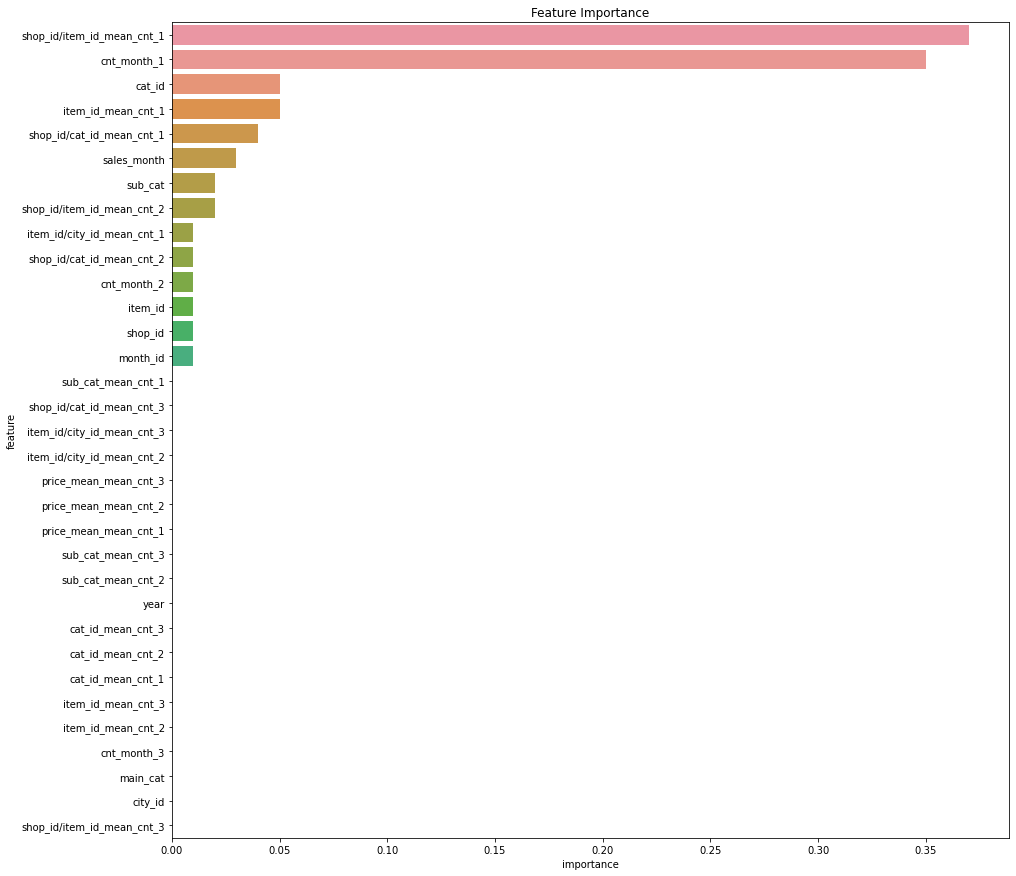

In [11]:
features = [i[0] for i in feature_importances]
importances = [i[1] for i in feature_importances]
feature_importance = pd.DataFrame({'feature':features,'importance':importances})

data = feature_importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(x=data['importance'], y=data['feature'])
plt.xlabel('importance')
plt.title('Feature Importance')

In [12]:
print('Train rmse: ',np.sqrt(mean_squared_error(y_train.clip(0,20), rf_train_pred)))
print('Validation rmse: ',np.sqrt(mean_squared_error(y_valid.clip(0,20), rf_valid_pred)))

Train rmse:  0.8873813688439268
Validation rmse:  0.8303080584637024


In [ ]:
print('Test rmse: ', )